In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the data
df = pd.read_csv('data.csv')
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2022,202201,NaN,16.0,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2022,202202,NaN,14.0,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2022,202203,NaN,24.0,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2022,202204,NaN,16.0,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2022,202205,NaN,24.0,NaN,NaN,NaN


In [3]:
# Dropping missing values
df.dropna(axis=0, inplace=True)

In [4]:
# Keeping only the month values in the month column
df['MONAT'] = df['MONAT'].str.slice(4, )
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
13,Alkoholunfälle,insgesamt,2021,01,16.0,28.0,23.08,-42.86,35.0
14,Alkoholunfälle,insgesamt,2021,02,14.0,40.0,-12.50,-65.00,33.0
15,Alkoholunfälle,insgesamt,2021,03,24.0,27.0,71.43,-11.11,32.0
16,Alkoholunfälle,insgesamt,2021,04,16.0,26.0,-33.33,-38.46,32.0
17,Alkoholunfälle,insgesamt,2021,05,24.0,40.0,50.00,-40.00,30.0


In [5]:
# Dropping Last 4 Columns
df.drop(columns=df.columns[-4:], axis=1, inplace=True)

In [6]:
# Renaming columns from german to english
df = df.rename(columns={'MONATSZAHL': 'Category', 'AUSPRAEGUNG': 'Type', 
                'JAHR': 'Year', 'MONAT': 'Month', 'WERT': 'Value'})

In [7]:
# Making a list of features
features = list(df.columns)
features

['Category', 'Type', 'Year', 'Month', 'Value']

In [8]:
# Printing some important feature information
for feature in features:
    print(f"{feature} has {df[feature].nunique()} unique values")
    
for feature in features[:2]:
    print(f'\n{feature}') 
    for category in df[feature].unique():
        print(f"{category} has {df[df[feature] == category].shape[0]} entries")

Category has 3 unique values
Type has 3 unique values
Year has 21 unique values
Month has 12 unique values
Value has 824 unique values

Category
Alkoholunfälle has 502 entries
Fluchtunfälle has 504 entries
Verkehrsunfälle has 756 entries

Type
insgesamt has 756 entries
Verletzte und Getötete has 754 entries
mit Personenschäden has 252 entries


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762 entries, 13 to 2072
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  1762 non-null   object 
 1   Type      1762 non-null   object 
 2   Year      1762 non-null   int64  
 3   Month     1762 non-null   object 
 4   Value     1762 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 82.6+ KB


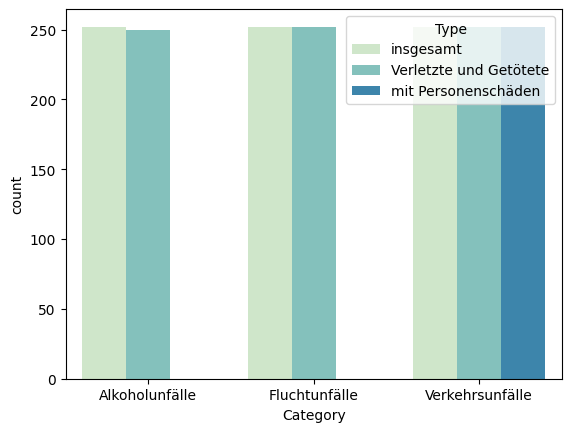

In [10]:
# Countplot of different categories with hue as type
sns.countplot(x='Category', data=df, palette='GnBu', hue='Type')
plt.show()

In [11]:
# Encodings for Month and Year. Month is being encoded using Cyclic Encoding and Year is being encoded using Label Encoding
def encode_month(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

min_year = df['Year'].min()

def encode_year(data):
    min = data['Year'].min()
    data['Year'] = data['Year'] - min

In [12]:
# Since there are different categories with same year and same month, the model can get confused when forecasting.
# We'll only consider the insgesamt (all-in-all) type 
# 3 models will be built, each for different category. 

In [13]:
df = df[df['Type'] == 'insgesamt']

In [14]:
# Encoding the Data
df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.month
df = encode_month(df, 'Month', 12)
encode_year(df)
months = df['Month'] # Storing the months in a list

In [15]:
category_map = {}
category_map = dict(enumerate(df['Category'].astype('category').cat.categories))
df['Category']=df['Category'].astype('category').cat.codes

In [16]:
category_map

{0: 'Alkoholunfälle', 1: 'Fluchtunfälle', 2: 'Verkehrsunfälle'}

In [17]:
# Dropping type as it is same for each data point
df.drop('Type', axis=1, inplace=True)

In [18]:
# Function to split df into different categories and types
def split_df(df, category):
    return df[(df['Category'] == category)]

In [19]:
y = {}

In [23]:
# A function to create our datasets. Validation Dataset is of 2020 and Test Dataset is of 2021
def train_test_split(data, category):
    new_df = split_df(data, category)
    test = new_df[new_df['Year'] == 20]
    train = new_df[new_df['Year'] < 19]
    val = new_df[new_df['Year'] == 19]
    X_train = train.drop('Value', axis=1)
    y_train = train['Value']
    X_val = val.drop('Value', axis=1)
    y_val = val['Value']
    X_test = test.drop('Value', axis=1)
    y_test = test['Value']
    test_months = test['Month']
    train_months = train['Month']
    val_months = val['Month']
    X_train.drop(['Month', 'Category'], axis=1, inplace=True)
    X_val.drop(['Month', 'Category'], axis=1, inplace=True)
    X_test.drop(['Month', 'Category'], axis=1, inplace=True)
    y[category] = {}
    y[category]['true'] = [y_val, y_test]
    return X_train, y_train, X_val, y_val, X_test, y_test, test_months, train_months, val_months

In [24]:
values = train_test_split(df, 0) # Alkoholunfälle Category
X_train, y_train, X_val, y_val, X_test, y_test, test_months, train_months, val_months = values

In [27]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse

In [56]:
# Training the XGB Model
reg0 = xgb.XGBRegressor(n_estimators=100)
reg0.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=500,
        verbose=True)

[0]	validation_0-rmse:32.59991	validation_1-rmse:27.98918
[1]	validation_0-rmse:23.95931	validation_1-rmse:21.29816
[2]	validation_0-rmse:17.93498	validation_1-rmse:17.12586
[3]	validation_0-rmse:13.83043	validation_1-rmse:14.54181
[4]	validation_0-rmse:11.00116	validation_1-rmse:12.92829
[5]	validation_0-rmse:9.01737	validation_1-rmse:11.50520
[6]	validation_0-rmse:7.65770	validation_1-rmse:10.72996
[7]	validation_0-rmse:6.72291	validation_1-rmse:10.32048
[8]	validation_0-rmse:6.07636	validation_1-rmse:9.88239
[9]	validation_0-rmse:5.45930	validation_1-rmse:9.56705
[10]	validation_0-rmse:5.11417	validation_1-rmse:9.56410
[11]	validation_0-rmse:4.76842	validation_1-rmse:9.27638
[12]	validation_0-rmse:4.54420	validation_1-rmse:9.28264
[13]	validation_0-rmse:4.28396	validation_1-rmse:9.35122
[14]	validation_0-rmse:4.01356	validation_1-rmse:9.39193
[15]	validation_0-rmse:3.87270	validation_1-rmse:9.36314
[16]	validation_0-rmse:3.75478	validation_1-rmse:9.44068
[17]	validation_0-rmse:3.626

f:\Data Science\environments\pytorch-env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[75]	validation_0-rmse:0.65777	validation_1-rmse:10.58208
[76]	validation_0-rmse:0.63370	validation_1-rmse:10.58373
[77]	validation_0-rmse:0.61945	validation_1-rmse:10.58457
[78]	validation_0-rmse:0.59158	validation_1-rmse:10.58384
[79]	validation_0-rmse:0.56297	validation_1-rmse:10.57869
[80]	validation_0-rmse:0.55767	validation_1-rmse:10.58018
[81]	validation_0-rmse:0.55033	validation_1-rmse:10.57868
[82]	validation_0-rmse:0.53386	validation_1-rmse:10.60308
[83]	validation_0-rmse:0.52844	validation_1-rmse:10.60336
[84]	validation_0-rmse:0.51421	validation_1-rmse:10.60584
[85]	validation_0-rmse:0.50549	validation_1-rmse:10.60620
[86]	validation_0-rmse:0.50204	validation_1-rmse:10.62601
[87]	validation_0-rmse:0.48711	validation_1-rmse:10.62485
[88]	validation_0-rmse:0.46968	validation_1-rmse:10.62601
[89]	validation_0-rmse:0.46692	validation_1-rmse:10.64023
[90]	validation_0-rmse:0.45758	validation_1-rmse:10.64203
[91]	validation_0-rmse:0.44497	validation_1-rmse:10.64096
[92]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [57]:
# Predicting values
y_val_pred0 = reg0.predict(X_val)
y_test_pred0 = reg0.predict(X_test)
y[0]['preds'] = [y_val_pred0, y_test_pred0]

In [60]:
# Function to get mean squared error for validation and test datasets
def get_mse(category):
    y_val_true = y[category]['true'][0]
    y_test_true = y[category]['true'][1]
    y_val_preds = y[category]['preds'][0]
    y_test_preds = y[category]['preds'][1]
    print(f'MSE Results for {category_map[category]} Category Validation: {mse(y_val_true, y_val_preds)}')
    print(f'MSE Results for {category_map[category]} Category Test: {mse(y_test_true, y_test_preds)}')

In [61]:
get_mse(0)

MSE Results for Alkoholunfälle Category Validation: 86.05118150512983
MSE Results for Alkoholunfälle Category Test: 99.21687415242802


In [62]:
# making a new dataframe for forecasts
new_df = pd.concat([X_val, X_test], axis=0)
new_df['Value'] = np.concatenate([y_val, y_test], axis=0)
new_df['Predicted'] = np.concatenate([y[0]['preds'][0], y[0]['preds'][1]], axis=0)
new_df['Month'] = np.concatenate([val_months, test_months], axis=0)

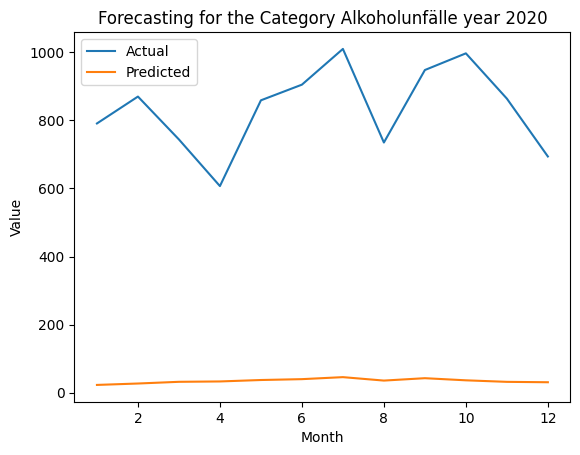

In [75]:
# Forecast plotting for validation data: year 2020
def plot_forecast_2020(data, category):
    sns.lineplot(x='Month', y='Value', data=new_df[:12])
    sns.lineplot(x='Month', y='Predicted', data=new_df[:12])
    plt.title(f'Forecasting for the Category {category_map[category]} year 2020')
    plt.legend(['Actual', 'Predicted'])
    plt.show()

plot_forecast_2020(new_df, 0)

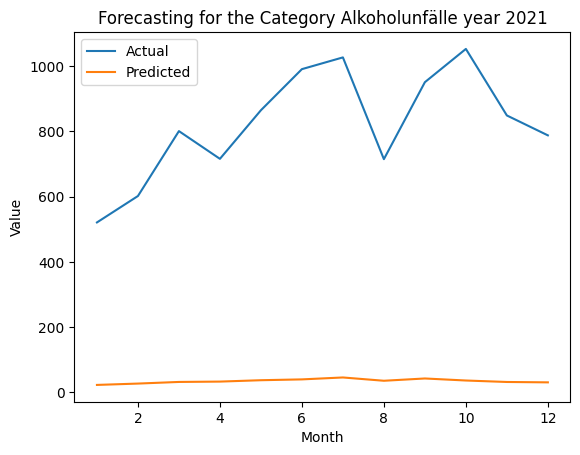

In [76]:
# Forecast Plotting function for test data: year 2021
def plot_forecast_2021(data, category):
    sns.lineplot(x='Month', y='Value', data=new_df[12:])
    sns.lineplot(x='Month', y='Predicted', data=new_df[12:])
    plt.title(f'Forecasting for the Category {category_map[category]} year 2021')
    plt.legend(['Actual', 'Predicted'])
    plt.show()

plot_forecast_2021(new_df, 0)

In [65]:
import pickle
file_name = "xgb_reg0.pkl"

# save
pickle.dump(reg0, open(file_name, "wb"))

# load
# xgb_model_loaded = pickle.load(open(file_name, "rb")

In [92]:
values = train_test_split(df, 1) # Fluchtunfälle Category
X_train, y_train, X_val, y_val, X_test, y_test, test_months, train_months, val_months = values

In [93]:
reg1 = xgb.XGBRegressor(n_estimators=500)
reg1.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=100,
        verbose=True)

[0]	validation_0-rmse:630.06754	validation_1-rmse:584.99275
[1]	validation_0-rmse:451.37743	validation_1-rmse:389.82926
[2]	validation_0-rmse:328.44022	validation_1-rmse:259.52656
[3]	validation_0-rmse:242.98466	validation_1-rmse:176.91498
[4]	validation_0-rmse:183.66980	validation_1-rmse:129.97008
[5]	validation_0-rmse:143.41228	validation_1-rmse:108.70211
[6]	validation_0-rmse:116.55203	validation_1-rmse:108.32704
[7]	validation_0-rmse:98.79604	validation_1-rmse:120.30157
[8]	validation_0-rmse:82.77641	validation_1-rmse:127.44120
[9]	validation_0-rmse:73.14904	validation_1-rmse:135.09995
[10]	validation_0-rmse:68.22298	validation_1-rmse:143.88170
[11]	validation_0-rmse:64.67048	validation_1-rmse:150.63632
[12]	validation_0-rmse:62.74529	validation_1-rmse:156.62055
[13]	validation_0-rmse:57.33944	validation_1-rmse:159.49630
[14]	validation_0-rmse:53.18587	validation_1-rmse:163.16683
[15]	validation_0-rmse:49.90879	validation_1-rmse:164.83506
[16]	validation_0-rmse:48.34121	validation_

f:\Data Science\environments\pytorch-env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-rmse:14.34411	validation_1-rmse:173.30360
[52]	validation_0-rmse:13.74167	validation_1-rmse:173.31304
[53]	validation_0-rmse:13.19851	validation_1-rmse:173.37934
[54]	validation_0-rmse:12.50255	validation_1-rmse:173.43337
[55]	validation_0-rmse:12.12473	validation_1-rmse:173.63386
[56]	validation_0-rmse:11.58036	validation_1-rmse:173.69351
[57]	validation_0-rmse:11.19739	validation_1-rmse:173.76490
[58]	validation_0-rmse:10.70311	validation_1-rmse:173.60687
[59]	validation_0-rmse:10.11718	validation_1-rmse:173.59729
[60]	validation_0-rmse:9.81593	validation_1-rmse:173.64508
[61]	validation_0-rmse:9.44599	validation_1-rmse:173.62412
[62]	validation_0-rmse:9.22138	validation_1-rmse:173.66666
[63]	validation_0-rmse:9.06334	validation_1-rmse:173.54624
[64]	validation_0-rmse:8.77729	validation_1-rmse:173.57546
[65]	validation_0-rmse:8.50058	validation_1-rmse:173.46941
[66]	validation_0-rmse:8.15254	validation_1-rmse:173.47861
[67]	validation_0-rmse:7.91860	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [94]:
y_val_pred1 = reg1.predict(X_val)
y_test_pred1 = reg1.predict(X_test)
y[1]['preds'] = [y_val_pred1, y_test_pred1]

In [95]:
get_mse(1)

MSE Results for Fluchtunfälle Category Validation: 11734.747222992903
MSE Results for Fluchtunfälle Category Test: 15353.196980886782


In [96]:
new_df = pd.concat([X_val, X_test], axis=0)
new_df['Value'] = np.concatenate([y_val, y_test], axis=0)
new_df['Predicted'] = np.concatenate([y[1]['preds'][0], y[1]['preds'][1]], axis=0)
new_df['Month'] = np.concatenate([val_months, test_months], axis=0)

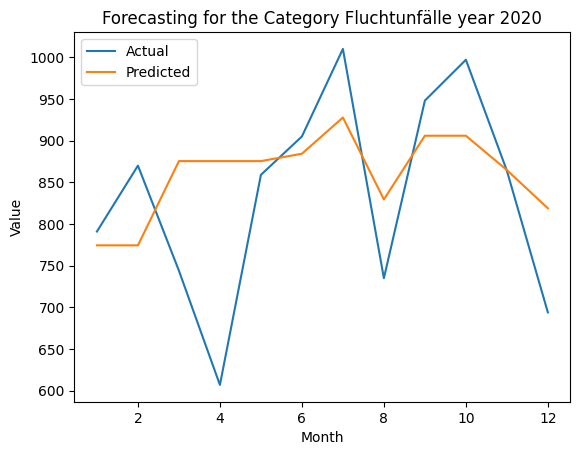

In [97]:
plot_forecast_2020(new_df, 1)

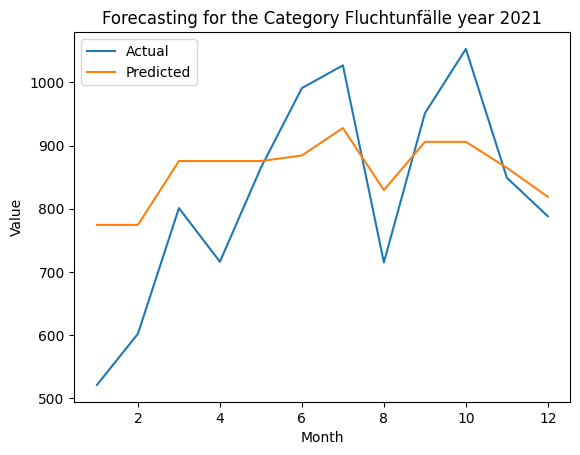

In [98]:
plot_forecast_2021(new_df, 1)

In [99]:
file_name = "xgb_reg1.pkl"

# save
pickle.dump(reg1, open(file_name, "wb"))

In [100]:
values = train_test_split(df, 2) # Fluchtunfälle Category
X_train, y_train, X_val, y_val, X_test, y_test, test_months, train_months, val_months = values

In [101]:
reg2 = xgb.XGBRegressor(n_estimators=500)
reg2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=100,
        verbose=True)

[0]	validation_0-rmse:2529.46639	validation_1-rmse:2113.30295
[1]	validation_0-rmse:1799.60070	validation_1-rmse:1347.28747
[2]	validation_0-rmse:1291.76943	validation_1-rmse:881.18549
[3]	validation_0-rmse:941.37929	validation_1-rmse:569.41038
[4]	validation_0-rmse:690.34984	validation_1-rmse:454.82970
[5]	validation_0-rmse:520.60713	validation_1-rmse:466.55043
[6]	validation_0-rmse:399.28611	validation_1-rmse:515.37141
[7]	validation_0-rmse:316.42884	validation_1-rmse:556.94187
[8]	validation_0-rmse:259.23396	validation_1-rmse:605.17634
[9]	validation_0-rmse:221.57994	validation_1-rmse:635.80157
[10]	validation_0-rmse:195.69770	validation_1-rmse:667.55755
[11]	validation_0-rmse:176.75436	validation_1-rmse:685.26977
[12]	validation_0-rmse:165.56067	validation_1-rmse:701.15841
[13]	validation_0-rmse:157.11017	validation_1-rmse:714.81932
[14]	validation_0-rmse:151.76929	validation_1-rmse:720.37849
[15]	validation_0-rmse:146.39736	validation_1-rmse:728.26442
[16]	validation_0-rmse:138.00

f:\Data Science\environments\pytorch-env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[66]	validation_0-rmse:26.24207	validation_1-rmse:743.05315
[67]	validation_0-rmse:25.17660	validation_1-rmse:742.90933
[68]	validation_0-rmse:24.81603	validation_1-rmse:742.86507
[69]	validation_0-rmse:24.28603	validation_1-rmse:743.30571
[70]	validation_0-rmse:23.66790	validation_1-rmse:743.02739
[71]	validation_0-rmse:23.47022	validation_1-rmse:742.71543
[72]	validation_0-rmse:23.23392	validation_1-rmse:742.48857
[73]	validation_0-rmse:22.57086	validation_1-rmse:742.46155
[74]	validation_0-rmse:21.89908	validation_1-rmse:742.21156
[75]	validation_0-rmse:21.40930	validation_1-rmse:741.99972
[76]	validation_0-rmse:21.03927	validation_1-rmse:741.95121
[77]	validation_0-rmse:20.70608	validation_1-rmse:742.84049
[78]	validation_0-rmse:20.55727	validation_1-rmse:742.85925
[79]	validation_0-rmse:20.17516	validation_1-rmse:742.77101
[80]	validation_0-rmse:19.75646	validation_1-rmse:742.84708
[81]	validation_0-rmse:19.20591	validation_1-rmse:742.51667
[82]	validation_0-rmse:18.68972	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [102]:
y_val_pred2 = reg1.predict(X_val)
y_test_pred2 = reg1.predict(X_test)
y[2]['preds'] = [y_val_pred2, y_test_pred2]

In [103]:
get_mse(2)

MSE Results for Verkehrsunfälle Category Validation: 5704363.633321218
MSE Results for Verkehrsunfälle Category Test: 5593408.117848806


In [104]:
new_df = pd.concat([X_val, X_test], axis=0)
new_df['Value'] = np.concatenate([y_val, y_test], axis=0)
new_df['Predicted'] = np.concatenate([y[2]['preds'][0], y[2]['preds'][1]], axis=0)
new_df['Month'] = np.concatenate([val_months, test_months], axis=0)

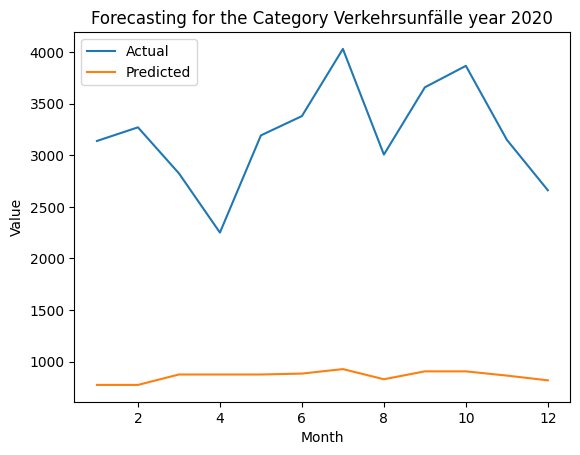

In [105]:
plot_forecast_2020(new_df, 2)

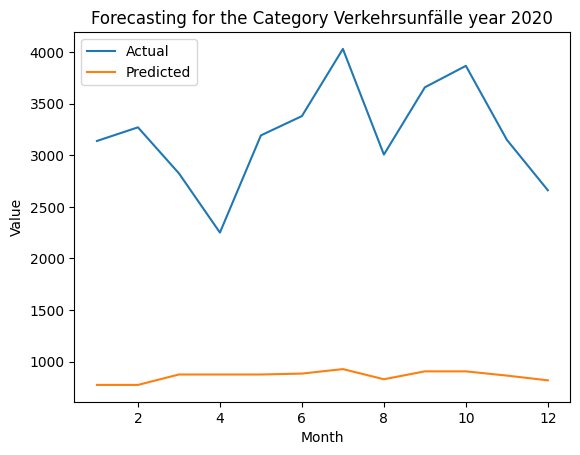

In [106]:
plot_forecast_2020(new_df, 2)

In [107]:
file_name = "xgb_reg2.pkl"

# save
pickle.dump(reg2, open(file_name, "wb"))